In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def cart2sph(cart):
	xy2 = cart[:,0]**2 + cart[:,1]**2
	sph = np.zeros_like(cart) #np.zeros(cart.shape) #
	sph[:,0] = np.sqrt(xy2 + cart[:,2]**2)
	sph[:,1] = np.arctan2(np.sqrt(xy2), cart[:,2]) # Elevation angle defined from Z-axis down
	sph[:,2] = np.arctan2(cart[:,1], cart[:,0])
	return sph

In [3]:
x = np.array([[1.0,  1.0,  0.]])
x_s = cart2sph(x)
x.shape, x_s.shape, x, x_s , np.degrees(x_s[0,2]), np.degrees(x_s[0,1])

((1, 3),
 (1, 3),
 array([[1., 1., 0.]]),
 array([[1.41421356, 1.57079633, 0.78539816]]),
 45.0,
 90.0)

In [2]:
def block_doa(frm_val, block_size):
    n_blocks = frm_val.shape[1]// block_size + 1

    blk_doas = []
    blk_start = 0
    for blk_idx in range(0, n_blocks):

        if blk_idx < n_blocks-1:
            blk_end = blk_start + block_size
        else:
            blk_end = blk_start + frm_val.shape[1]

        blk_sum = torch.sum(frm_val[:,blk_start:blk_end],dim=1)
        blk_doa_idx = torch.argmax(blk_sum)
        blk_doa = blk_doa_idx

        blk_start = blk_end

        blk_doas.append(blk_doa)

    return blk_doas

#for now taking absolute inside the block
def block_lbl_doa(lbl_doa, block_size):
    #assuming lbl_doa [r, elv, azi] : (1, frms, 3)
    n_blocks = lbl_doa.shape[1]// block_size + 1

    blk_doas = []
    blk_range = []
    blk_start = 0
    for blk_idx in range(0, n_blocks):
        if blk_idx < n_blocks-1:
            blk_end = blk_start + block_size
        else:
            blk_end = blk_start + lbl_doa.shape[1]

        blk_doa = torch.mean(torch.abs(lbl_doa[:,blk_start:blk_end, : ]),dim=1)

        blk_start = blk_end
        blk_doas.append(torch.rad2deg(blk_doa[:,2])) # azimuth
        blk_range.append(blk_doa[:,0]) # range

    return blk_doas, blk_range

def blk_vad(frm_level_vad, block_size):
    #assuming frm_level_vad : (frms)
    n_blocks = frm_level_vad.shape[0]// block_size + 1

    frm_level_vad = 1.0*frm_level_vad
    blk_vads = []
    blk_start = 0
    for blk_idx in range(0, n_blocks):
        if blk_idx < n_blocks-1:
            blk_end = blk_start + block_size
        else:
            blk_end = blk_start + frm_level_vad.shape[0]

        _blk_vad = torch.mean(frm_level_vad[blk_start:blk_end])

        blk_start = blk_end
        blk_vads.append(_blk_vad)
    return blk_vads


In [3]:
tol = 5

def get_acc(est_vad, est_blk_val, tgt_blk_val, tol=5, vad_th=0.6):
    n_blocks = len(est_vad)
    non_vad_blks =[]
    acc=0
    valid_blk_count = 0
    for idx in range(0, n_blocks):
        if est_vad[idx] >=vad_th:
            if (np.abs(est_blk_val[idx] - np.abs(tgt_blk_val[idx])) <= tol):
                acc += 1
            valid_blk_count +=1
        else:
            non_vad_blks.append(idx)

    acc /= valid_blk_count
    
    #print(f'n_blocks: {n_blocks}, non_vad_blks: {non_vad_blks}')
    return acc

In [ ]:
scenario = "source_moving"
snr =  -5
t60 = 0.2
src_mic_dist = 1.0
noi_mic_dist = 1.0

idx=0
#read the config file
#
scratch_dir='/scratch/bbje/battula12/ControlledExp/Testing/Scenario_Comparision/'
file_path = f'../val_dataset_file_circular_motion_snr_{snr}_t60_{t60}.txt' #dataset_file_10sec.txt'

with open(file_path) as f:
    configs_lst = [line.strip().split(',')[-1] for line in f.readlines()]


config_file = configs_lst[idx]

cfg = torch.load(config_file)

config_dict = cfg #circular_motion_config_dict
room_sz = config_dict['room_sz']
mic_pos = config_dict['mic_pos']
traj_pts= config_dict['src_traj_pts']
noise_pos= config_dict['noise_pos']
T60= config_dict['t60']
SNR= config_dict['snr']

noise_pos =  np.expand_dims(noise_pos, axis=0) if len(noise_pos.shape) == 1 else noise_pos


array_pos = np.mean(mic_pos, axis=0, keepdims=True)
noise_spherical = cart2sph(noise_pos-array_pos)

#range motion of source
print(f' Noise range: {noise_spherical[:,0]}, elevation: {np.degrees(noise_spherical[:,1])}, azimuth : {np.degrees(noise_spherical[:,2]) }')


mix_t60_lst = []
est_t60_lst = []
mvng_t60_lst = []

mix_frm_t60_lst = []
est_frm_t60_lst = []
mvng_frm_t60_lst = []

for t60 in [0.2]:
    mix_avg_lst = []
    est_avg_lst = []
    mvng_avg_lst = []

    mix_metric_avg_lst = []
    est_metric_avg_lst = []
    mvng_est_metric_avg_lst = []
    
    mix_frm_avg_lst = []
    est_frm_avg_lst = []
    mvng_frm_avg_lst = []
    pp_str = f'{scratch_dir}signals/{scenario}/from_val_dataset_circular_motion_snr_{snr}_t60_{t60}_src_mic_dist_{src_mic_dist}_noi_mic_dist_{noi_mic_dist}/'  #from_dataset_file_10sec/v2/'
    for batch_idx in range(0, 640): #idx, idx+1
        app_str = f'{batch_idx}'

        #app_str = f'sp_{static_prob}_nlp_{non_linear_motion_prob}_snr_{test_snr}_t60_{test_t60}_nb_points_{nb_points}'

        info = torch.load(f'{pp_str}doa_{app_str}.pt')

        #### 
        mix_metrics = info['mix_metrics']
        est_metrics = info['est_metrics']
        mvng_est_metrics = info['mvng_est_metrics']

        est_metrics = list(est_metrics.values())
        mix_metrics = list(mix_metrics.values())
        mvng_est_metrics = list(mvng_est_metrics.values())

        
        est_metric_avg_lst.append(est_metrics)
        mix_metric_avg_lst.append(mix_metrics)
        mvng_est_metric_avg_lst.append(mvng_est_metrics)



        (mix_f_doa, mix_f_vals, mix_sig_vad, mix_utt_doa, mix_utt_sum) = info['mix']
        (tgt_f_doa, tgt_f_vals, tgt_sig_vad, tgt_utt_doa, tgt_utt_sum) = info['tgt']
        (est_f_doa, est_f_vals, est_sig_vad, est_utt_doa, est_utt_sum) = info['est']
        (mvng_est_f_doa, mvng_est_f_vals, mvng_est_sig_vad, mvng_est_utt_doa, mvng_est_utt_sum) = info['mvng_est']
        lbl_doa = info['lbl_doa']


        mix_frm_Acc = get_acc(np.array(tgt_sig_vad), np.array(mix_f_doa), np.array(tgt_f_doa),vad_th=0.6)
        est_frm_Acc = get_acc(np.array(tgt_sig_vad), np.array(est_f_doa), np.array(tgt_f_doa),vad_th=0.6)
        mvng_frm_Acc = get_acc(np.array(tgt_sig_vad), np.array(mvng_est_f_doa), np.array(tgt_f_doa),vad_th=0.6)


        mix_frm_avg_lst.append(mix_frm_Acc)
        est_frm_avg_lst.append(est_frm_Acc)
        mvng_frm_avg_lst.append(mvng_frm_Acc)
        

        blk_size = 25
        mix_blk_vals = block_doa(frm_val=mix_f_vals, block_size=blk_size)
        tgt_blk_vals = block_doa(frm_val=tgt_f_vals, block_size=blk_size)
        est_blk_vals = block_doa(frm_val=est_f_vals, block_size=blk_size)
        mvng_est_blk_vals = block_doa(frm_val=mvng_est_f_vals, block_size=blk_size)

        lbl_blk_doa, lbl_blk_range = block_lbl_doa(lbl_doa, block_size=blk_size)

        mix_blk_vad = blk_vad(mix_sig_vad, blk_size)
        tgt_blk_vad = blk_vad(tgt_sig_vad, blk_size)
        est_blk_vad = blk_vad(est_sig_vad, blk_size)
        mvng_blk_vad = blk_vad(mvng_est_sig_vad, blk_size)

        mix_Acc = get_acc(np.array(tgt_blk_vad), np.array(mix_blk_vals), np.array(tgt_blk_vals))
        est_Acc = get_acc(np.array(tgt_blk_vad), np.array(est_blk_vals), np.array(tgt_blk_vals))
        mvng_est_Acc = get_acc(np.array(tgt_blk_vad), np.array(mvng_est_blk_vals), np.array(tgt_blk_vals))

        mix_avg_lst.append(mix_Acc)
        est_avg_lst.append(est_Acc)
        mvng_avg_lst.append(mvng_est_Acc)

    mvng_est_avg_metrics = np.array(mvng_est_metric_avg_lst)
    est_avg_metrics = np.array(est_metric_avg_lst)
    mix_avg_metrics = np.array(mix_metric_avg_lst)

    mvng_est_Avg = np.mean(mvng_est_avg_metrics, axis=0)
    est_Avg = np.mean(est_avg_metrics, axis=0)
    mix_Avg = np.mean(mix_avg_metrics, axis=0)

    mix_t60_lst.append(np.mean(np.array(mix_avg_lst)))
    est_t60_lst.append(np.mean(np.array(est_avg_lst)))
    mvng_t60_lst.append(np.mean(np.array(mvng_avg_lst)))

    
    mix_frm_t60_lst.append(np.mean(np.array(mix_frm_avg_lst)))
    est_frm_t60_lst.append(np.mean(np.array(est_frm_avg_lst)))
    mvng_frm_t60_lst.append(np.mean(np.array(mvng_frm_avg_lst)))

In [ ]:
mix_Acc, est_Acc, mvng_est_Acc, mix_frm_Acc, est_frm_Acc, mvng_frm_Acc

In [ ]:
mix_Avg, est_Avg, mvng_est_Avg

In [ ]:
info['mix_metrics'], info['est_metrics'], info['mvng_est_metrics']

In [ ]:
src_azimuth = np.degrees(cart2sph(traj_pts-array_pos)[:,2])
src_azimuth_keys = np.round(np.where(src_azimuth<0, 360+src_azimuth, src_azimuth)).astype('int32')	

In [ ]:
src_azimuth, src_azimuth_keys, src_azimuth_keys-180

In [ ]:
mvng_est_blk_vals, est_blk_vals

In [ ]:
plt.figure()
plt.plot(tgt_blk_vals,'b')
plt.plot(est_blk_vals,'g')
plt.plot(mvng_est_blk_vals,'r')
plt.plot(mix_blk_vals, 'o')
#plt.plot(src_azimuth, 'b+')

In [ ]:
plt.figure()
plt.plot(tgt_blk_vad,'b')
plt.plot(est_blk_vad,'g')
plt.plot(mvng_blk_vad,'r')
plt.plot(mix_blk_vad, 'o')

In [ ]:
np.array(tgt_blk_vals)-np.array(mvng_est_blk_vals), np.array(tgt_blk_vals)-np.array(est_blk_vals)

In [12]:
#Rigorours doa analysis 
import torch
import numpy as np
batch_idx = 0
tol = 7.5
euclid_dist=True

dataset_condition = "reverb"
dataset_dtype = "stationary"
app_str = f'{batch_idx}'
t60=0.61

#info =torch.load(f'../signals/real_rirs_dbg/doa_{batch_idx}_{t60}_dp_t60_0_train_MIMO_RI.pt', map_location=torch.device('cpu')) #tr_s_test_{dataset_dtype}_{dataset_condition}_{t60}doa_{app_str}.pt')
info =torch.load(f'../signals/real_rirs_dbg/doa_{t60}_{batch_idx}_tol_{tol}deg_euclid_{euclid_dist}_4mic_rir_dp_t60_0_train_MIMO_RI_PD_mag_compression.pt', map_location=torch.device('cpu')) #tr_s_test_{dataset_dtype}_{dataset_condition}_{t60}doa_{app_str}.pt')
#(mix_f_doa, mix_f_vals, mix_sig_vad, mix_utt_doa, mix_utt_sum) = info['mix']
#(tgt_f_doa, tgt_f_vals, tgt_sig_vad, tgt_utt_doa, tgt_utt_sum) = info['tgt']
#(est_f_doa, est_f_vals, est_sig_vad, est_utt_doa, est_utt_sum) = info['est']


#ref_f_doa[0]

(mix_f_doa, mix_f_vals, mix_utt_doa) = info['mix']
(tgt_f_doa, tgt_f_vals, tgt_sig_vad, tgt_utt_doa) = info['tgt']  #, tgt_unweighted_freq_vals, tgt_freq_vals
(est_f_doa, est_f_vals, est_utt_doa) = info['est'] #, est_unweighted_freq_vals, est_freq_vals

doa = info['doa']
ref_f_doa = torch.rad2deg(doa[:,:,-1])[0,:mix_f_doa.shape[0]]

mix_frm_Acc = get_acc(np.array(tgt_sig_vad), np.array(mix_f_doa), np.array(tgt_f_doa),tol = tol, vad_th=0.6)
est_frm_Acc = get_acc(np.array(tgt_sig_vad), np.array(est_f_doa), np.array(tgt_f_doa),tol = tol, vad_th=0.6)


blk_size = 399 #25*15
mix_blk_vals = block_doa(frm_val=mix_f_vals, block_size=blk_size)
tgt_blk_vals = block_doa(frm_val=tgt_f_vals, block_size=blk_size)
est_blk_vals = block_doa(frm_val=est_f_vals, block_size=blk_size)

#lbl_blk_doa, lbl_blk_range = block_lbl_doa(lbl_doa, block_size=blk_size)
tgt_blk_vad = blk_vad(tgt_sig_vad, blk_size)

#mix_Acc = get_acc(np.array(tgt_blk_vad), np.array(mix_blk_vals), np.array(tgt_blk_vals))
#est_Acc = get_acc(np.array(tgt_blk_vad), np.array(est_blk_vals), np.array(tgt_blk_vals))


print(dataset_dtype, mix_frm_Acc, est_frm_Acc) #, mix_Acc, est_Acc)
print(ref_f_doa[0], mix_utt_doa, est_utt_doa)

stationary 0.8518518518518519 0.9470899470899471
tensor(105.) tensor(105) tensor(106)


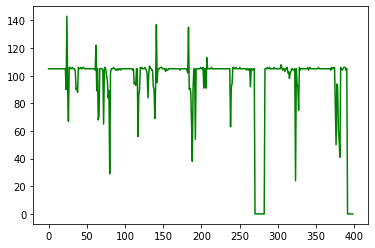

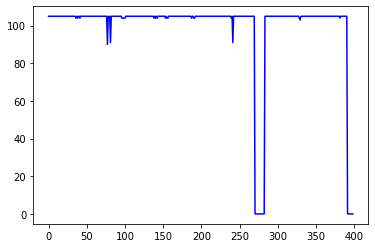

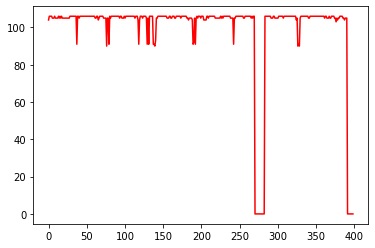

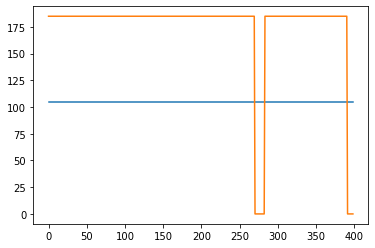

In [13]:
plt.plot(mix_f_doa,'g')
plt.figure()
plt.plot(tgt_f_doa,'b')
plt.figure()
plt.plot(est_f_doa,'r')
plt.figure()
plt.plot(ref_f_doa)
plt.plot(np.array(tgt_sig_vad)*185)

In [ ]:
np.where(np.abs(est_f_doa-ref_f_doa)>5)

In [ ]:
plt.plot(np.abs(est_f_doa-ref_f_doa))

In [ ]:
tgt_freq_vals[0].shape

In [ ]:
frm = 70
print(np.argmax(tgt_f_vals[:, frm]), (np.argmax(est_f_vals[:, frm])))
plt.plot(tgt_f_vals[:, frm], 'b')
plt.plot(est_f_vals[:, frm], 'r')

In [ ]:
frm = 70
freq_end = 43 #160
#theta = 105
for theta in range(0,180,15):
    plt.plot(tgt_unweighted_freq_vals[theta][frm,:], 'b')
    plt.plot(est_unweighted_freq_vals[theta][frm,:], 'r')
    print(theta, torch.sum(est_unweighted_freq_vals[theta][frm,:]), torch.sum(est_unweighted_freq_vals[theta][frm,:freq_end]))
    plt.title(theta)
    plt.figure()

In [ ]:
frm = 43
#theta = 105
for theta in range(0,180,15):
    plt.plot(tgt_freq_vals[theta][frm,:], 'b')
    plt.plot(est_freq_vals[theta][frm,:], 'r')
    print(theta, torch.sum(est_freq_vals[theta][frm,:]), torch.sum(est_freq_vals[theta][frm,:freq_end]))
    plt.title(theta)
    plt.figure()
    #plt.pause(0.5)

In [ ]:
mix_blk_vals, tgt_blk_vals, est_blk_vals

In [ ]:
doa = info['doa']
ref_f_doa = torch.rad2deg(doa[:,:,-1])[0,:mix_f_doa.shape[0]]
ref_f_doa[0]

In [ ]:
mix_frm_Acc = get_acc(np.array(tgt_sig_vad), np.array(mix_f_doa), np.array(ref_f_doa),tol = 5, vad_th=0.6)
est_frm_Acc = get_acc(np.array(tgt_sig_vad), np.array(est_f_doa), np.array(ref_f_doa),tol = 5, vad_th=0.6)

print(dataset_dtype, mix_frm_Acc, est_frm_Acc)

In [ ]:
#plt.plot(tgt_f_doa)
plt.plot(est_f_doa)
plt.plot(ref_f_doa)
plt.plot(np.array(tgt_sig_vad)*185)
plt.figure()
plt.plot(tgt_blk_vals)
plt.plot(est_blk_vals)
#plt.plot(ref_f_doa[0]*np.ones(len(est_blk_vals)))

In [ ]:
est_f_vals.shape

In [ ]:
frm = 65
plt.plot(tgt_f_vals[:,frm])

In [ ]:
import torchaudio
from masked_gcc_phat import compute_vad
tgt_sig, fs = torchaudio.load(f'../signals/real_rirs_dbg/tgt_{batch_idx}.wav')
est_sig, fs = torchaudio.load(f'../signals/real_rirs_dbg/est_{batch_idx}.wav')
frame_size, frame_shift= 320,160
sig_vad_1 = compute_vad(tgt_sig[0,:].cpu().numpy(), frame_size, frame_shift)
sig_vad_2 = compute_vad(tgt_sig[1,:].cpu().numpy(), frame_size, frame_shift)
tgt_sig_vad_c = sig_vad_1*sig_vad_2
tgt_sig_vad_c = tgt_sig_vad_c

sig_vad_1 = compute_vad(est_sig[0,:].cpu().numpy(), frame_size, frame_shift)
sig_vad_2 = compute_vad(est_sig[1,:].cpu().numpy(), frame_size, frame_shift)
est_sig_vad = sig_vad_1*sig_vad_2
est_sig_vad = est_sig_vad


#plt.plot(tgt_sig_vad_c)
plt.plot(0.8*tgt_sig_vad)
plt.plot(est_sig_vad)
plt.plot()

In [ ]:
mix_frm_Acc = get_acc(np.array(est_sig_vad), np.array(mix_f_doa), np.array(ref_f_doa),tol = 5, vad_th=0.6)
est_frm_Acc = get_acc(np.array(est_sig_vad), np.array(est_f_doa), np.array(ref_f_doa),tol = 5, vad_th=0.6)

print(dataset_dtype, mix_frm_Acc, est_frm_Acc)

In [ ]:
25*16

In [ ]:
direction_act = 165
theta_act = (direction_act)/180.0*torch.pi 
act_d = np.sqrt(1.0016 - 0.08*np.cos(theta_act)) - np.sqrt(1.0016 + 0.08*np.cos(theta_act))

diff_omg_64 = []
diff_omg_32 = []
for idx in range(0, 257):
    omg = 2*torch.pi*16000*1.0/320*idx
    diff_t = []
    diff_t_32 = []

    for direction in range(0, 180):
        theta  = (direction)/180.0*torch.pi 
        ph_diff = 1*np.cos( omg*(  act_d - ( np.sqrt(1.0016 - 0.08*np.cos(theta)) - np.sqrt(1.0016 + 0.08*np.cos(theta))))/343 )
        diff_t.append(ph_diff)
        diff_t_32.append(ph_diff.astype(np.float32))

    diff_omg_64.append(diff_t)
    diff_omg_32.append(diff_t_32)
    #plt.plot(diff_t)
    #plt.pause(0.1)

In [ ]:
np.argmax(diff_omg[20])

In [ ]:
print(diff_omg_64[20][150:])

In [ ]:
print(diff_omg_32[20][150:])

In [ ]:
diff_omg[20][165].dtype

In [ ]:
est_f_vals.dtype

In [ ]:
frm = 70
freq_end = 43 #160
#theta = 105
incl_spatial_aliasing_lst = []
excl_spatial_aliasing_lst = []

for theta in range(0,180,1):
    #plt.plot(tgt_unweighted_freq_vals[theta][frm,:], 'b')
    #plt.plot(est_unweighted_freq_vals[theta][frm,:], 'r')
    incl_spatial_aliasing_lst.append(torch.sum(tgt_freq_vals[theta][frm,:]))
    excl_spatial_aliasing_lst.append(torch.sum(tgt_freq_vals[theta][frm,:freq_end]))
    #print(theta, torch.sum(est_unweighted_freq_vals[theta][frm,:]), torch.sum(est_unweighted_freq_vals[theta][frm,:freq_end]))
    #plt.title(theta)
    #plt.figure()

plt.plot(incl_spatial_aliasing_lst,'b')
plt.plot(excl_spatial_aliasing_lst, 'r')

In [ ]:
torch.sum(est_unweighted_freq_vals[theta][frm,:]), torch.sum(est_unweighted_freq_vals[theta][frm,:freq_end]), torch.sum(est_unweighted_freq_vals[theta][frm,freq_end:])

In [ ]:
print(est_unweighted_freq_vals[theta][frm,:freq_end])

In [ ]:
print(est_unweighted_freq_vals[theta][frm,:])

In [23]:
# mimo loss doa_comparison
#Rigorours doa analysis 
import torch
import numpy as np
batch_idx = 4
tol = 5.0
euclid_dist=True

dataset_condition = "reverb"
dataset_dtype = "stationary"
app_str = f'{batch_idx}'
t60=1.0

#info =torch.load(f'../signals/real_rirs_dbg/doa_{batch_idx}_{t60}_dp_t60_0_train_MIMO_RI.pt', map_location=torch.device('cpu')) #tr_s_test_{dataset_dtype}_{dataset_condition}_{t60}doa_{app_str}.pt')
info =torch.load(f'../signals/simu_rirs_dbg/loss_function_comparison/doa_{t60}_{batch_idx}_0_tol_{tol}deg_euclid_{euclid_dist}.pt', map_location=torch.device('cpu')) #tr_s_test_{dataset_dtype}_{dataset_condition}_{t60}doa_{app_str}.pt')
info_1 =torch.load(f'../signals/simu_rirs_dbg/loss_function_comparison/doa_{t60}_{batch_idx}_1_tol_{tol}deg_euclid_{euclid_dist}.pt', map_location=torch.device('cpu')) #tr_s_test_{dataset_dtype}_{dataset_condition}_{t60}doa_{app_str}.pt')
#(mix_f_doa, mix_f_vals, mix_sig_vad, mix_utt_doa, mix_utt_sum) = info['mix']
#(tgt_f_doa, tgt_f_vals, tgt_sig_vad, tgt_utt_doa, tgt_utt_sum) = info['tgt']
#(est_f_doa, est_f_vals, est_sig_vad, est_utt_doa, est_utt_sum) = info['est']


#ref_f_doa[0]

(mix_f_doa, mix_f_vals, mix_utt_doa) = info['mix']
(tgt_f_doa, tgt_f_vals, tgt_sig_vad, tgt_utt_doa, _, _) = info['tgt']  #, tgt_unweighted_freq_vals, tgt_freq_vals
(est_f_doa, est_f_vals, est_utt_doa, _, _) = info['est'] #, est_unweighted_freq_vals, est_freq_vals

(est_f_doa_1, est_f_vals_1, est_utt_doa_1, _, _) = info_1['est'] #, est_unweighted_freq_vals, est_freq_vals

doa = info['doa']
ref_f_doa = torch.rad2deg(doa[:,:,-1])[0,:mix_f_doa.shape[0]]

mix_frm_Acc = get_acc(np.array(tgt_sig_vad), np.array(mix_f_doa), np.array(tgt_f_doa),tol = tol, vad_th=0.6)
est_frm_Acc = get_acc(np.array(tgt_sig_vad), np.array(est_f_doa), np.array(tgt_f_doa),tol = tol, vad_th=0.6)


#mix_Acc = get_acc(np.array(tgt_blk_vad), np.array(mix_blk_vals), np.array(tgt_blk_vals))
#est_Acc = get_acc(np.array(tgt_blk_vad), np.array(est_blk_vals), np.array(tgt_blk_vals))


print(dataset_dtype, mix_frm_Acc, est_frm_Acc) #, mix_Acc, est_Acc)
print(ref_f_doa[0], mix_utt_doa, est_utt_doa)

stationary 0.49828178694158076 0.5154639175257731
tensor(82.) tensor(85.) tensor(86.)


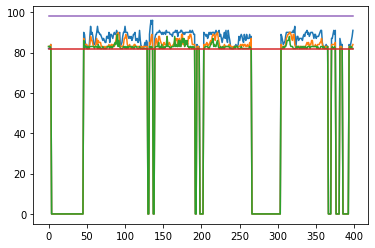

In [24]:
plt.plot(est_f_doa)
plt.plot(est_f_doa_1)
plt.plot(tgt_f_doa)
plt.plot(torch.abs(ref_f_doa))
plt.plot(180-torch.abs(ref_f_doa))